# Pruebas nuevo ForecasterAutoregMultiseries (0.12.0)

Funcionalidades a probar:

+ Series es dataframe y exog es dataframe

+ Series es dataframe y exog es diccionario con distintas exógenas para cada serie

+ Series es diccionario y exog es diccionario

+ Series es diccionario con series de diferente longitud:
    + Se almacena correctamente last_window
    + ¿Que series se permiten predecir?
    + ¿Que series se permiten predecir si se le pasa un last_window?

+ Series es diccionario y exog es diccionario con algunas exógenas con valores ausentes

+ Comparar impacto de diferentes encodings en terminos de predicción y tiempos de ejecución

In [30]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
import joblib

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
set_dark_theme()

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Auxiliar functions
# ==============================================================================
def series_long_format_to_dict(
    data: pd.DataFrame,
    series_id: str,
    index: str,
    values: str,
    freq: str,
):
    """
    Convert long format series to dictionary.

    Parameters
    ----------
    data: pd.DataFrame
        Long format series.
    series_id: str
        Column name with the series identifier.
    index: str
        Column name with the time index.
    values: str
        Column name with the values.
    freq: str
        Frequency of the series.

    Returns
    -------
    series_dict: dict
        Dictionary with the series.

    """

    series_dict = {}
    for k, v in data.groupby(series_id):
        series_dict[k] = v.set_index(index)[values].asfreq(freq).rename(k)

    return series_dict


def exog_long_format_to_dict(
    data: pd.DataFrame,
    series_id: str,
    index: str,
    freq: str
):
    """
    Convert long format exogenous variables to dictionary.

    Parameters
    ----------
    data: pd.DataFrame
        Long format exogenous variables.
    series_id: str
        Column name with the series identifier.
    index: str
        Column name with the time index.
    freq: str
        Frequency of the series.
    
    Returns
    -------
    exog_dict: dict
        Dictionary with the exogenous variables.

    """

    exog_dict =  dict(tuple(data.groupby(series_id)))
    exog_dict = {
        k: v.set_index(index).asfreq(freq).drop(columns=series_id)
        for k, v in exog_dict.items()
    }

    return exog_dict

In [32]:
# Load data
# ==============================================================================
# series_dict = joblib.load('sample_multi_series.joblib')
# exog_dict = joblib.load('sample_multi_series_exog.joblib')

series = pd.read_csv('sample_multi_series.csv')
exog = pd.read_csv('sample_multi_series_exog.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])


series_dict = series_long_format_to_dict(
    data = series,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_format_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

series_df = pd.DataFrame(series_dict)

In [33]:
# Partition data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'

series_df_train   = series_df.loc[: end_train, :].copy()
series_df_val     = series_df.loc[end_train:end_validation, :].copy()
series_df_test    = series_df.loc[end_validation:, :].copy()
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_val   = {k: v.loc[end_train: end_validation] for k, v in series_dict.items()}
exog_dict_val     = {k: v.loc[end_train: end_validation,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_validation:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_validation:,] for k, v in exog_dict.items()}

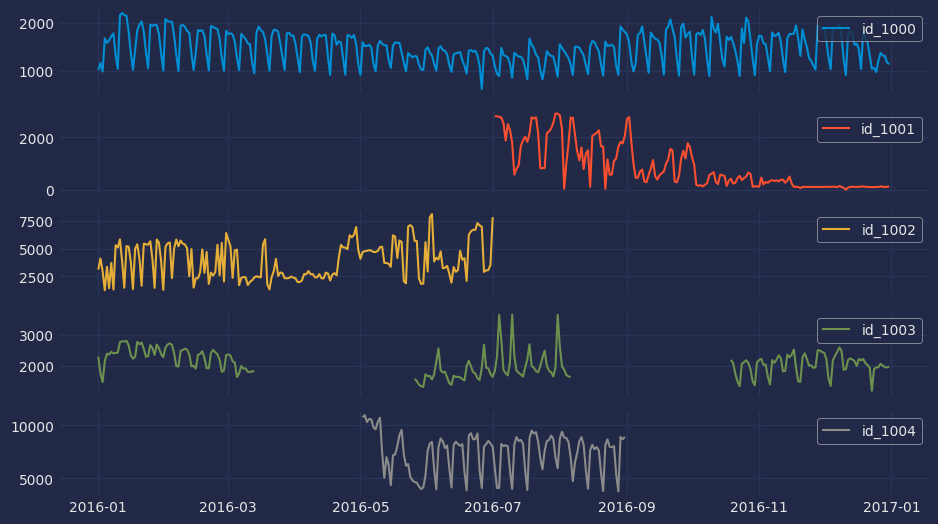

In [34]:
# Plot series
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right')

In [35]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"    Train: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"    Train: len=0")
    try:
        print(
            f"    Val  : len={len(series_dict_val[k])}, {series_dict_val[k].index[0]}"
            f" --- {series_dict_val[k].index[-1]}"
        )
    except:
        print(f"    Val  : len=0")
    try:
        print(
            f"    Test : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"    Test : len=0")

id_1000:
    Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
    Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
    Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
    Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
    Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
    Val  : len=0
    Test : len=0
id_1003:
    Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
    Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
    Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
    Val  : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00
    Test : len=0


In [36]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"    {exog_dict[k].columns.to_list()}")
    except:
        print(f"    No exogenous variables")

id_1000:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1001:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
    ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


# Series is dataframe and exog is dictionary

In [37]:
# Series is dataframe and exog is dictionary
# ==============================================================================

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_df_train, exog=exog_dict_train)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_1 = forecaster.predict(steps=5, exog=exog_dict_val)
predictions_1

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-04-03 00:16:35 
Last fit date: 2024-0

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1378.248757,2504.949597,2885.786739,7433.592705
2016-08-02,1488.250500,2523.968068,2662.873975,6996.187473
2016-08-03,1398.041547,2395.122080,2275.476591,8212.824729
2016-08-04,1407.998109,2267.671597,2175.450276,8613.980714
2016-08-05,1309.688355,2093.141027,2108.365877,8507.702905


# Series is dictionary and exog is dictionary

In [40]:
# Series is dictionary and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series_dict_train, exog=exog_dict_train)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_2 = forecaster.predict(steps=5, exog=exog_dict_val)
predictions_2

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-04-03 00:16:57 
Last fit date: 2024-0

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1378.248757,2504.949597,2885.786739,7433.592705
2016-08-02,1488.250500,2523.968068,2662.873975,6996.187473
2016-08-03,1398.041547,2395.122080,2275.476591,8212.824729
2016-08-04,1407.998109,2267.671597,2175.450276,8613.980714
2016-08-05,1309.688355,2093.141027,2108.365877,8507.702905


In [41]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)

# Series is dataframe with series of different lengths (filled with NaNs) and exog is None

In [42]:
# Series is dataframe with series of different lengths (filled with NaNs) and exog is None
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series_df)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: 'id_1000': ['2016-01-01', '2016-12-31'], 'id_1001': ['2016-01-01', '2016-12-31'], 'id_1002': ['2016-01-01', '2016-12-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-04-03 00:18:22 
Last fit date: 2024-04-03 00:18:22 
Skforecast version: 0.12.0 
Python version: 3.12.0 
Forecaste

In [43]:
print('Predictions')
print('------------')
predictions_3 = forecaster.predict(steps=5, levels=['id_1000'])
predictions_3

Predictions
------------


,id_1000
2017-01-01,1052.310058
2017-01-02,1348.389279
2017-01-03,1455.782936
2017-01-04,1415.239620
2017-01-05,1398.959955


In [44]:
print('Predictions')
print('------------')
predictions_4 = forecaster.predict(steps=5, levels=['id_1004'])
predictions_4

Predictions
------------


,id_1004
2016-09-01,8872.845743
2016-09-02,8211.528184
2016-09-03,5673.015082
2016-09-04,4063.923527
2016-09-05,8608.514987


In [45]:
print('Predictions')
print('------------')
predictions_5 = forecaster.predict(steps=5, levels=['id_1000', 'id_1004'])
predictions_5

Predictions
------------


c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:1297: IgnoredArgumentWarning: Only series whose last window ends at the same index can be predicted together. Series that not reach the maximum index, '2016-12-31 00:00:00', are excluded from prediction: {'id_1004'}. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


,id_1000
2017-01-01,1052.310058
2017-01-02,1348.389279
2017-01-03,1455.782936
2017-01-04,1415.239620
2017-01-05,1398.959955


In [46]:
print('Predictions')
print('------------')
predictions_6 = forecaster.predict(steps=5, levels=None)
predictions_6

Predictions
------------


,id_1000,id_1001,id_1003
2017-01-01,1052.310058,119.732235,2046.682242
2017-01-02,1348.389279,114.110698,2038.022302
2017-01-03,1455.782936,113.864170,2047.049785
2017-01-04,1415.239620,105.604602,1965.499059
2017-01-05,1398.959955,112.320310,1834.262846


In [47]:
pd.testing.assert_series_equal(predictions_6['id_1000'], predictions_5['id_1000'])

# Series is dictionaty with series of different lengths and exog is None

In [48]:
# Series is dataframe with series of different lengths (filled with NaNs) and exog is None
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
            )
forecaster.fit(series=series_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_9 = forecaster.predict(steps=5)
predictions_9

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: 'id_1000': ['2016-01-01', '2016-12-31'], 'id_1001': ['2016-07-02', '2016-12-31'], 'id_1002': ['2016-01-01', '2016-07-01'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-04-03 00:19:52 
Last fit date: 2024-04-03 00:19:52 
Skforecast version: 0.12.0 
Python version: 3.12.0 
Forecaste

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


,id_1000,id_1001,id_1003
2017-01-01,1052.310058,119.732235,2046.682242
2017-01-02,1348.389279,114.110698,2038.022302
2017-01-03,1455.782936,113.864170,2047.049785
2017-01-04,1415.239620,105.604602,1965.499059
2017-01-05,1398.959955,112.320310,1834.262846


In [20]:
pd.testing.assert_frame_equal(predictions_8, predictions_9)

# Series is dictionary with series of different lengths and exog is heterogeneous dictionary

id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=220, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=None
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


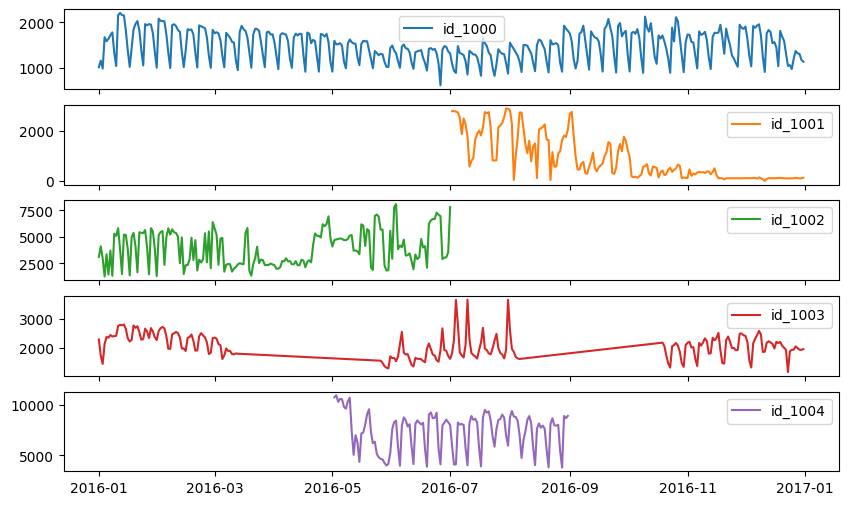

In [21]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
series_dict_train = {k : v.loc[: end_train].copy() for k, v in series_dict.items()}
series_dict_val   = {k : v.loc[end_train:end_validation].copy() for k, v in series_dict.items()}
series_dict_test  = {k : v.loc[end_validation:].copy() for k, v in series_dict.items()}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()


exog_dict_train = {building: exog_train.copy() for building in series_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in series_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in series_test.columns}
exog_dict_train['id_1000'] = exog_dict_train['id_1000'].drop(columns=['sin_day_of_week', 'cos_day_of_week'])
exog_dict_train['id_1001'] = exog_dict_train['id_1001'].drop(columns=['cos_day_of_week'])
exog_val_dict['id_1000']   = exog_val_dict['id_1000'].drop(columns=['sin_day_of_week', 'cos_day_of_week'])
exog_val_dict['id_1001']   = exog_val_dict['id_1001'].drop(columns=['cos_day_of_week'])
exog_test_dict['id_1000']  = exog_test_dict['id_1000'].drop(columns=['sin_day_of_week', 'cos_day_of_week'])
exog_test_dict['id_1001']  = exog_test_dict['id_1001'].drop(columns=['cos_day_of_week'])

In [22]:
# Series is dataframe and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'ordinal'
            )
forecaster.fit(series=series_dict_train, exog=exog_dict_train)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
predictions_10 = forecaster.predict(steps=5, exog=exog_val_dict)
predictions_10

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['air_temperature', 'wind_speed', 'sin_day_of_week', 'cos_day_of_week'] 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-03-31 14:06:49 
Last fit date: 2024-

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:847: MissingExogWarning: {'cos_day_of_week', 'sin_day_of_week'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:847: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1001'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.w

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1295.688799,2708.674620,4782.105699,2825.636469,7354.208890
2016-08-02,1476.869780,2552.956612,5288.290065,2296.480578,8723.957689
2016-08-03,1432.629648,2400.914433,5169.295773,2096.785368,9365.043600
2016-08-04,1372.899558,2416.142975,5202.936325,2004.178234,10038.891044
2016-08-05,1340.233155,2327.367259,5297.652085,1868.114938,10537.242005


id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=220, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=None
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


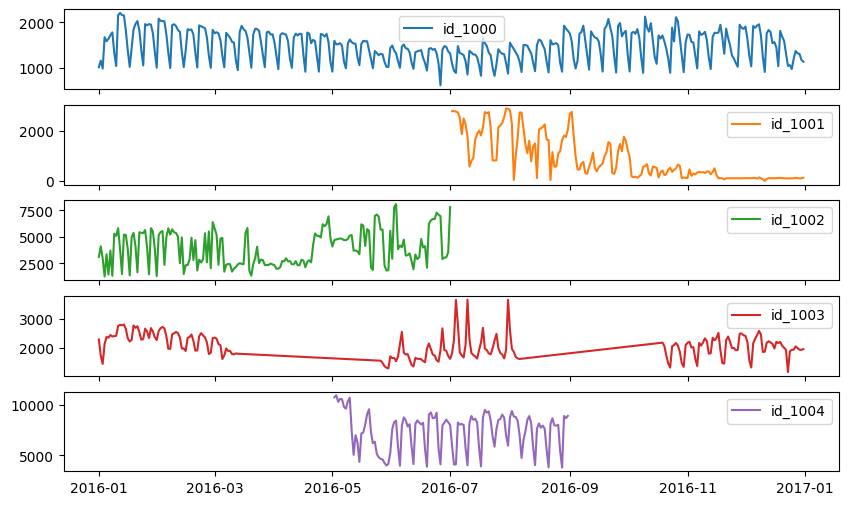

In [23]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
#series_dict = {col: series_dict[col].asfreq("D") for col in series_dict.keys()}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()

In [24]:
# Fin minimum and maximum index among all values of the dictionary
# ==============================================================================
min_index = min([v.index[0] for v in series_dict.values()])
max_index = max([v.index[-1] for v in series_dict.values()])
frequency = set([v.index.freqstr for v in series_dict.values() if v.index.freqstr is not None])

# checks if all series have the same frequency!!!!!!!!!!!!!!!
frequency = list(frequency)[0]
span_index = pd.date_range(min_index, max_index, freq=frequency)

print(f"min_index: {min_index}")
print(f"max_index: {max_index}")
print(f"frequency: {frequency}")

span_index


min_index: 2016-01-01 00:00:00
max_index: 2016-12-31 00:00:00
frequency: D


DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=366, freq='D')

In [25]:
# from skforecast.model_selection import _create_backtesting_folds
# y = pd.Series(np.arange(100))
# y.index = pd.date_range(start='2022-01-01', periods=100, freq='D')
# window_size = 3
# initial_train_size = 70
# test_size = 10
# refit = False

# folds = _create_backtesting_folds(
#             data                  = y,
#             window_size           = window_size,
#             initial_train_size    = initial_train_size,
#             test_size             = test_size,
#             externally_fitted     = False,
#             refit                 = refit,
#             fixed_train_size      = False,
#             gap                   = 0,
#             allow_incomplete_fold = True,
#             return_all_indexes    = False,
#             verbose               = True
#         )

# folds[0]

In [26]:
# from typing import Union, Optional, Tuple  

# def _extract_data_folds_multiseries(
#     series: Union[pd.Series, pd.DataFrame, dict],
#     folds: list,
#     exog: Optional[Union[pd.Series, pd.DataFrame, dict]] = None,
#     span_index: Optional[Union[pd.DatetimeIndex, pd.RangeIndex]] = None,
#     dropna_last_window: bool = False,
# ) -> Tuple[
#     Union[pd.Series, pd.DataFrame, dict],
#     pd.DataFrame,
#     list,
#     Union[pd.Series, pd.DataFrame, dict],
#     Union[pd.DatetimeIndex, pd.RangeIndex],
#     list,
# ]:
#     """
#     Select the data from series and exog that corresponds to each fold created using the
#     skforecast.model_selection._create_backtesting_folds function.

#     Parameters
#     ----------
#     series: pd.Series, pd.DataFrame, dict
#         Time series.
#     folds: list
#         Folds created using the skforecast.model_selection._create_backtesting_folds
#         function.
#     exog: pd.Series, pd.DataFrame, dict
#         Exogenous variable.
#     span_index: pd.DatetimeIndex, pd.RangeIndex
#         Full index from the minimum to the maximum index among all series.

#     Yield
#     -------
#     series_train: pd.Series, pd.DataFrame, dict
#         Time series corresponding to the training set of the fold.
#     series_last_window: pd.Series, pd.DataFrame, dict
#         Time series corresponding to the last window of the fold.
#     levels_last_window: list
#         Levels of the time series present to the last window of the fold.
#     exog_train: pd.Series, pd.DataFrame, dict
#         Exogenous variable corresponding to the training set of the fold.
#     exog_test: pd.Series, pd.DataFrame, dict
#         Exogenous variable corresponding to the test set of the fold.
#     span_index: pd.DatetimeIndex, pd.RangeIndex
#         Full index from the minimum to the maximum index among all series.
#     fold: list
#         Fold created using the skforecast.model_selection._create_backtesting_folds

#     """
#     for fold in folds:
#         train_iloc_start = fold[0][0]
#         train_iloc_end = fold[0][1]
#         last_window_iloc_start = fold[1][0]
#         last_window_iloc_end = fold[1][1]
#         test_iloc_start = fold[2][0]
#         test_iloc_end = fold[2][1]

#         logger.debug(
#             f"\n"
#             f"Train fold       : {train_iloc_start} - {train_iloc_end}\n"
#             f"Last window fold : {last_window_iloc_start} - {last_window_iloc_end}\n"
#             f"Test fold        : {test_iloc_start} - {test_iloc_end}"
#         )

#         if isinstance(series, dict) or isinstance(exog, dict):
#             if span_index is None:
#                 if isinstance(series, dict):
#                     min_index = min([v.index[0] for v in series.values()])
#                     max_index = max([v.index[-1] for v in series.values()])
#                     # All series must have the same frequency
#                     frequency = series[list(series.keys())[0]].index.freqstr
#                     span_index = pd.date_range(
#                         start=min_index, end=max_index, freq=frequency
#                     )
#                 else:
#                     span_index = series.index

#             train_loc_start = span_index[train_iloc_start]
#             train_loc_end = span_index[train_iloc_end]
#             last_window_loc_start = span_index[last_window_iloc_start]
#             last_window_loc_end = span_index[last_window_iloc_end]
#             test_loc_start = span_index[test_iloc_start]
#             test_loc_end = span_index[test_iloc_end]

#             logger.debug(
#                 f"\n"
#                 f"Train fold       : {train_loc_start} - {train_loc_end}\n"
#                 f"Last window fold : {last_window_loc_start} - {last_window_loc_end}\n"
#                 f"Test fold        : {test_loc_start} - {test_loc_end}"
#             )

#         if isinstance(series, pd.DataFrame):
#             series_train = series.iloc[train_iloc_start:train_iloc_end,]
#             series_last_window = series.iloc[
#                 last_window_iloc_start:last_window_iloc_end,
#             ]
#         else:
#             series_train = {
#                 k: v.loc[train_loc_start:train_loc_end] for k, v in series.items()
#             }
#             series_train = {k: v for k, v in series_train.items() if len(v) > 0}
#             series_last_window = {
#                 k: v.loc[last_window_loc_start:last_window_loc_end]
#                 for k, v in series.items()
#             }
#             series_last_window = pd.DataFrame(series_last_window)

#         if dropna_last_window:
#             series_last_window = series_last_window.dropna(axis=1, how="any")
#             # TODO: add the option to drop the series without minimum non NaN values.
#             # Similar to how pandas does in the rolling window function.
#         levels_last_window = list(series_last_window.columns)

#         if exog is not None:
#             if isinstance(exog, (pd.Series, pd.DataFrame)):
#                 exog_train = exog.iloc[train_iloc_start:train_iloc_end, :]
#                 exog_test = exog.iloc[test_iloc_start:test_iloc_end, :]
#             else:
#                 exog_train = {
#                     k: v.loc[train_loc_start:train_loc_end, :] for k, v in exog.items()
#                 }
#                 exog_train = {k: v for k, v in exog_train.items() if len(v) > 0}
#                 exog_test = {
#                     k: v.loc[test_loc_start:test_loc_end, :] for k, v in exog.items()
#                 }
#                 exog_test = {k: v for k, v in exog_test.items() if len(v) > 0}
#         else:
#             exog_train = None
#             exog_test = None

#         yield series_train, series_last_window, levels_last_window, exog_train, exog_test, span_index, fold

In [27]:
# from skforecast.model_selection_multiseries.model_selection_multiseries import _extract_data_fold_multiseries

# import logging
# from skforecast.model_selection_multiseries import model_selection_multiseries
# logger = logging.getLogger(model_selection_multiseries.__name__)
# logger.setLevel(logging.DEBUG)

# folds = [
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
#     [[0, 70], [67, 70], [70, 80], [70, 80], False],
# ]

# data_folds = _extract_data_folds_multiseries(series=series_dict, folds=folds, exog=exog, span_index=None)
# data_folds

## Backtesting: series is dataframe and exog is None

In [28]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series=False
            )

# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = 50,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 1,
                                           verbose               = True,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 50
Number of observations used for backtesting: 316
    Number of folds: 14
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2016-02-19 00:00:00  (n=50)
    Validation: 2016-02-20 00:00:00 -- 2016-03-14 00:00:00  (n=24)
Fold: 1
    Training:   2016-01-25 00:00:00 -- 2016-03-14 00:00:00  (n=50)
    Validation: 2016-03-15 00:00:00 -- 2016-04-07 00:00:00  (n=24)
Fold: 2
    Training:   2016-02-18 00:00:00 -- 2016-04-07 00:00:00  (n=50)
    Validation: 2016-04-08 00:00:00 -- 2016-05-01 00:00:00  (n=24)
Fold: 3
    Training:   2016-03-13 00:00:00 -- 2016-05-01 00:00:00  (n=50)
    Validation: 2016-05-02 00:00:00 -- 2016-05-25 00:00:00  (n=24)
Fold: 4
    Training:   2016-04-06 00:00:00 -- 2016-05-25 00:00:00  (n=50)


  0%|          | 0/14 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,185.953235,5.857820e+04
1,id_1001,472.346257,4.301278e+05
2,id_1002,1510.813225,3.629893e+06
3,id_1003,349.023566,2.384887e+05
4,id_1004,1001.115655,1.715415e+06



Backtest predictions


,id_1000,id_1002,id_1003,id_1004,id_1001
2016-02-20,1212.956697,3223.414080,2126.700240,NaN,NaN
2016-02-21,1100.710860,3595.415366,2139.723208,NaN,NaN
2016-02-22,1354.913153,2788.744848,2222.261651,NaN,NaN
2016-02-23,1573.521251,3649.466675,2242.896263,NaN,NaN


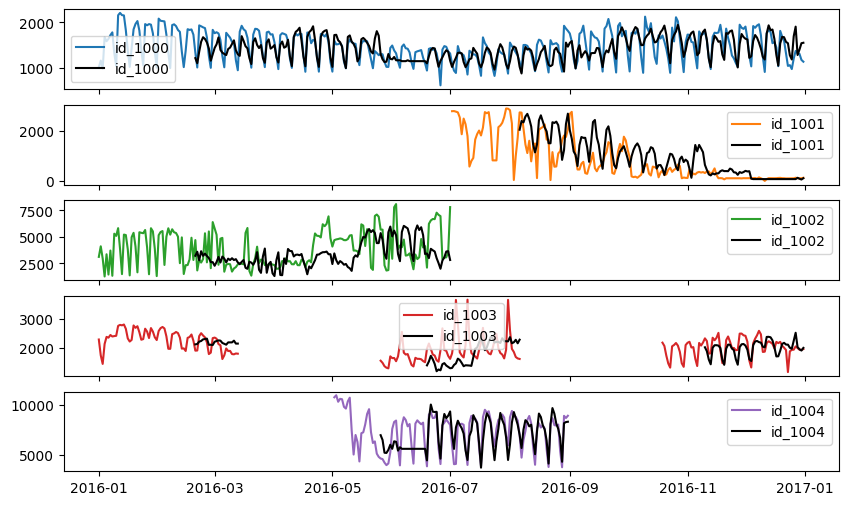

In [29]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

## Backtesting: series is dict and exog is None

id_1000: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1001: length=183, index=2016-07-02 00:00:00...2016-12-31 00:00:00, freq=D
id_1002: length=183, index=2016-01-01 00:00:00...2016-07-01 00:00:00, freq=D
id_1003: length=366, index=2016-01-01 00:00:00...2016-12-31 00:00:00, freq=D
id_1004: length=122, index=2016-05-02 00:00:00...2016-08-31 00:00:00, freq=D


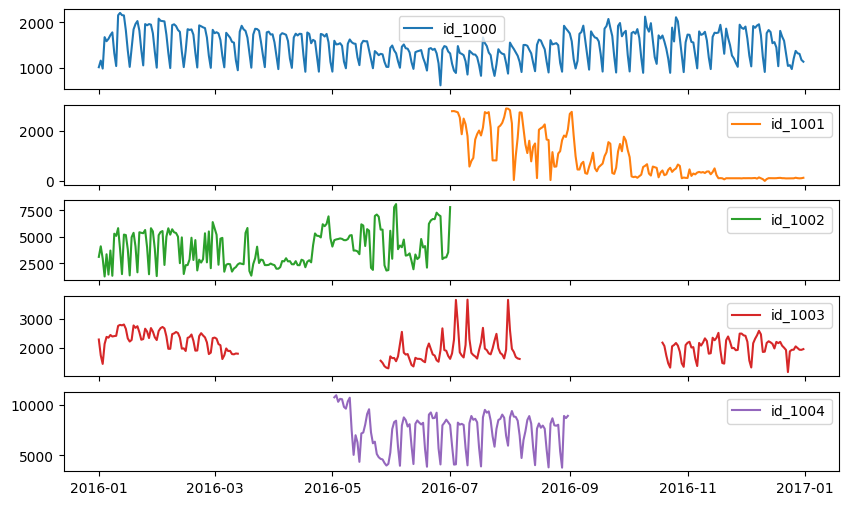

In [47]:
series['id_1000'] = series['id_1000']
series['id_1001'].iloc[0:int(len(series)/2)]  = np.nan
series['id_1002'].iloc[int(len(series)/2):]  = np.nan
series['id_1003'].iloc[int(len(series)/5): 2*int(len(series)/5)]  = np.nan
series['id_1003'].iloc[3*int(len(series)/5): 4*int(len(series)/5)]  = np.nan
series['id_1004'].iloc[: int(len(series)/3)]  = np.nan
series['id_1004'].iloc[2*int(len(series)/3):]  = np.nan

series_dict = {col: series[col].dropna() for col in series.columns}
series_dict = {col: series_dict[col].asfreq("D") for col in series_dict.keys()}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series_dict.values()):
    print(f"{s.name}: length={len(s)}, index={s.index[0]}...{s.index[-1]}, freq={s.index.freqstr}")
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend()

In [48]:
series_dict['id_1002'].at['2016-02-01'] = np.nan

series_dict['id_1002'].at['2016-05-01'] = np.nan

In [32]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series= False
            )
forecaster.fit(series=series_dict, suppress_warnings=False)

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:767: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:767: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarning: NaNs detected in `X_train`. Some regressor do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:767: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped since the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:790: MissingValuesWarni

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,190.673434,6.024335e+04
1,id_1001,472.346257,4.301278e+05
2,id_1002,1601.410583,4.001583e+06
3,id_1003,346.856873,2.363924e+05
4,id_1004,1025.527032,1.719722e+06



Backtest predictions


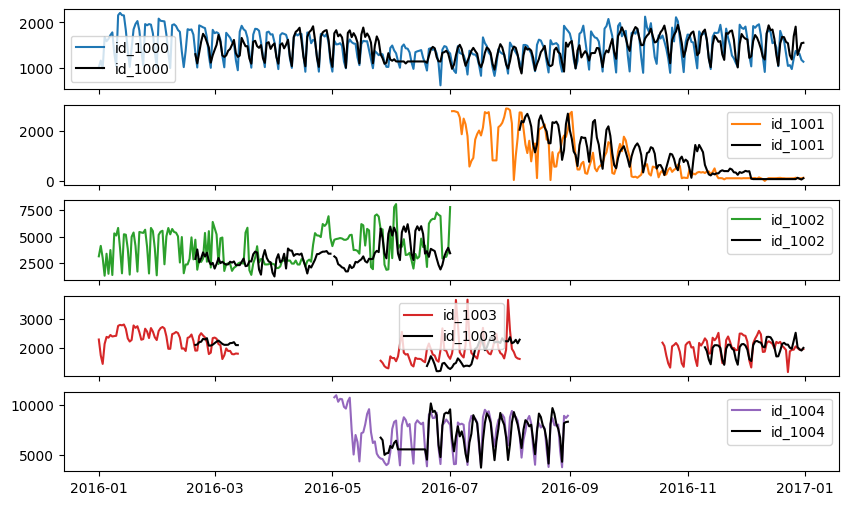

In [51]:
# import warnings
# from skforecast.exceptions import MissingValuesWarning
# warnings.simplefilter('ignore', category=MissingValuesWarning)

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series= False
            )

# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series_dict,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = 50,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 1,
                                           verbose               = False,
                                           show_progress         = True,
                                           suppress_warnings=False
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

In [43]:
series_dict['id_1002'].at['2016-02-01'] = 1000

series_dict['id_1002'].at['2016-05-01'] = 2000

In [44]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot',
                dropna_from_series= True
            )
forecaster.fit(series=series_dict, suppress_warnings=True)

In [45]:
forecaster.series_col_names

['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']

  0%|          | 0/15 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error
0,id_1000,97.325226,2.018969e+04
1,id_1001,261.702238,1.628551e+05
2,id_1002,1002.471695,1.720915e+06
3,id_1003,148.822789,4.702778e+04
4,id_1004,580.297714,6.570378e+05



Backtest predictions


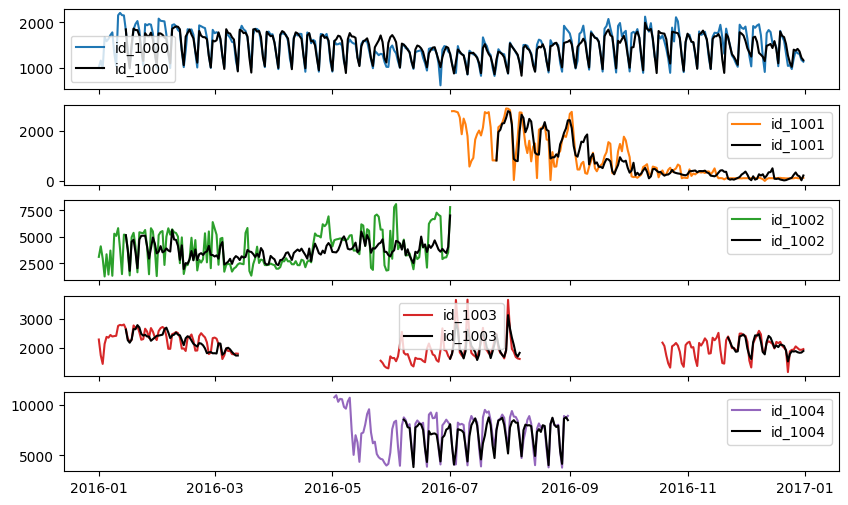

In [46]:
# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = series_dict,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = ['mean_absolute_error', 'mean_squared_error'],
                                           initial_train_size    = None,
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           n_jobs                = 1,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, s in enumerate(series.columns):
    axs[i].plot(series[s], label=series[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend()

# Puntos a revisar

+ ¿Exog en el predict tiene que ser necesariamente un dataframe? Ahora mismo hay conflicto de tipos. Predict espera un exog del mismo tipo que en train, pero tiene un check que en predict solo permite dataframe o serie. Si el forecaster se entrena con dict falla.

In [25]:
levels_in_backtest_predictions = [
    'l1', 'l1_lower_bound', 'l1_upper_bound',
    'l2', 'l2_lower_bound', 'l2_upper_bound',
    'l3', 'l3_lower_bound', 'l3_upper_bound',
]
levels_in_backtest_predictions

['l1',
 'l1_lower_bound',
 'l1_upper_bound',
 'l2',
 'l2_lower_bound',
 'l2_upper_bound',
 'l3',
 'l3_lower_bound',
 'l3_upper_bound']

In [26]:
import re

levels_in_backtest_predictions = [
    level 
    for level in levels_in_backtest_predictions
    if not re.search(r'_lower_bound|_upper_bound', level)
]
levels_in_backtest_predictions

['l1', 'l2', 'l3']

'l1'